# Classfiying CIFAR10 dataset using a deep neural network

## Importing the libraries

In [26]:
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt


## Importing the dataset

In [27]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert X_test.shape == (10000, 32, 32, 3)
assert y_test.shape == (10000, 1)


In [28]:
label_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

## Show some images

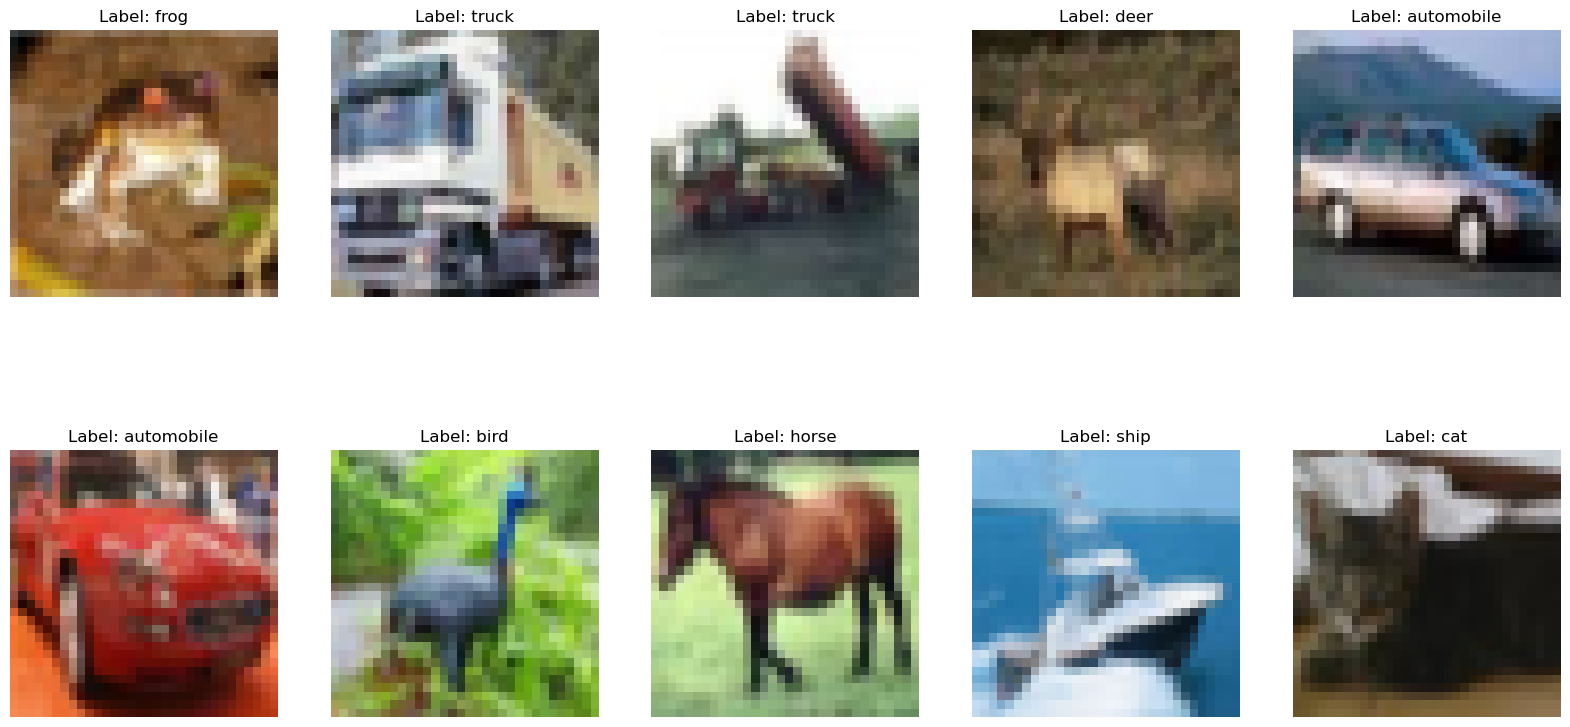

In [30]:
plt.figure(figsize=(20,10))

for i in range(10):
    subplt = plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title('Label: {}'.format(label_dict[y_train[i][0]]))


## Preprocessing the data

In [31]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Designing a simple multilayer perceptron model